In [8]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage import io
from scipy.io import loadmat
from tqdm.notebook import tqdm

from scipy.integrate import solve_ivp
from scipy.interpolate import RectBivariateSpline, griddata, LinearNDInterpolator

import os

In [9]:
def advect(u, x, y, t, t_span, t_eval=None, initial_conds=None, interp_kwargs=None, solver_kwargs=None):
    """
    Advect points (initial conditions) by flow field.

    Seeds streamlines at arbitrary initial conditions,
    specified by the initial_conds array. Can deal with
    both time-dependent and independent velocity fields.
    
    Parameters
    ----------
    u : ndarray of shape (n_timepoints, n_rows, n_cols, 2)
        Vector field values at grid points. u[:,:,:,0] is the x-component,
        u[:,:,:,1] the y-component. If u is a 3d array (len(u.shape) == 3),
        the vector field is assumed to be constant in time.
    x : ndarray of shape (n_cols,)
        Array of x-coordinate values. x[i] == x-coord for u[:,:,i].
        Coordinates must be strictly ascending.
    y : ndarray (n_rows,)
        Array of y-coordinate values. y[i] == y-coord for u[:,i,:].
        Coordinates must be strictly ascending.
    t : ndarry of shape (n_timepoints,)
        Array of times at which vector field is sampled, in strictly
        ascending order.  If the vector field is time independent
        (len(u.shape) == 3), this argument is ignored (just pass None).
    t_span : 2-tuple of floats
        Interval of integration (t0, tf).
    t_eval : np.array, otional.
        Times at which to evaluate the flow. Defaults to
        np.arange(t_span[0], t_span[1]+1), so phi[0] == initial conditions.
    initial_conds : ndarrray of dimension (N, 2)
        Array of initial conditions
    interp_kwargs  : dict, optional
        Parameters for the scipy.interpolate.RectBivariateSpline interpolator,
        see scipy docs. In particular, one can choose the order
        (linear, cubic, ...) and the smoothing paramter.
    solver_kwargs : dict, optional
        Parameters for the scipy ODE solver solve_ivp, see scipy docs.
        The default is {'method'='LSODA', 'rtol'=1e-05}.

    Returns
    -------
    phi : ndarray of shape (#timepoints, n_rows, n_cols, 2)
        Flow of vector field. phi[:,i,j,:] is the trajectory of
        point y[i], y[j], with phi[:,i,j,0] being the x-coordinate
        and phi[:,i,j,1] the y-coordinate. If dense_output is True, return
        array (n_rows, n_cols, 2) of OdeSolution objects.

    """
    ## preliminary argument parsing
    # ensure correct dtype - if coords are ints, errors can occur
    x = x.astype(float, copy=False)
    y = y.astype(float, copy=False)
    initial_conds = initial_conds.astype(float, copy=False)
    if t_eval is None:
        t_eval = np.arange(t_span[0], t_span[1]+1)
    if interp_kwargs is None:
        interp_kwargs = {}
    if solver_kwargs is None:
        solver_kwargs = {'method': 'RK45', 'rtol': 1e-05}
    solver_kwargs['t_eval'] = t_eval
    solver_kwargs['vectorized'] = True

    ## set up interpolator
    if len(u.shape) == 3:  # time-independent vector field
        interp_x = RectBivariateSpline(y, x, u[:, :, 0], **interp_kwargs)
        interp_y = RectBivariateSpline(y, x, u[:, :, 1], **interp_kwargs)

        def rhs(tpt, pts):
            return np.stack([interp_x(pts[1], pts[0]),
                             interp_y(pts[1], pts[0])])
    elif len(u.shape) == 4:
        # RectBivariateSpline can only deal with 2d interpolation.
        # Use a different interpolator for each time point,
        # then interpolate linearly in time between those functions.
        interp_x = [RectBivariateSpline(y, x, vf[:, :, 0], **interp_kwargs)
                    for vf in u]
        interp_y = [RectBivariateSpline(y, x, vf[:, :, 1], **interp_kwargs)
                    for vf in u]
        max_i = len(t)-1

        def rhs(tpt, pts):
            i = np.searchsorted(t, tpt, side='right')
            i = i if i < max_i else max_i
            delta = t[i] - t[i-1]
            val_a = np.stack([interp_x[i-1](pts[1], pts[0]),
                              interp_y[i-1](pts[1], pts[0])])
            val_b = np.stack([interp_x[i](  pts[1], pts[0]),
                              interp_y[i](  pts[1], pts[0])])
            return ((t[i]-tpt)*val_a + (tpt - t[i-1])*val_b)/delta

    ## iterate over initial conditions.
    phi = []
    for x_0 in tqdm(initial_conds):
        out = solve_ivp(rhs, t_span, x_0, **solver_kwargs)
        assert out['status'] != -1, "integration failed"
        phi.append(out['y'])
        
    return np.stack(phi).transpose(2,0,1)

In [10]:
def smooth_aniso(img, sigma=(15, 5)):
    img_out = ndimage.gaussian_filter1d(img, axis=0, sigma=sigma[0])
    img_out = ndimage.gaussian_filter1d(img_out, axis=1, sigma=sigma[1])
    
    return img_out

def normalize(img, qs=(.05, .95)):
    img_out = (img-np.quantile(img, qs[0]))/(np.quantile(img, qs[1])-np.quantile(img, qs[0]))
    return img_out

In [11]:
def pad_img(img, pad_width=500):
    img_out = np.concatenate([img[-pad_width:], img, img[:pad_width] ], axis=0)
    img_out = np.concatenate([img_out, img_out[:, -pad_width:][:, ::-1]], axis=-1)
        
    return img_out

## Load PIV and get trajectories

In [12]:
## load piv

root_path = "data"

piv_mat = loadmat(os.path.join(root_path,"PIVlab.mat"))
x, y = (piv_mat["x"][0,0], piv_mat["y"][0,0])

vel = np.stack([np.stack(piv_mat["u_filtered"][:,0]), np.stack(piv_mat["v_filtered"][:,0])], axis=-1)

sigma = 3
vel_smoothed = ndimage.gaussian_filter1d(ndimage.gaussian_filter1d(vel, axis=1, sigma=sigma),
                                         axis=2, sigma=sigma)
vel_smoothed = ndimage.gaussian_filter1d(vel_smoothed, axis=0, sigma=2)

(197, 189, 138, 2)


(23.0, 2199.0, 21.0, 3029.0)

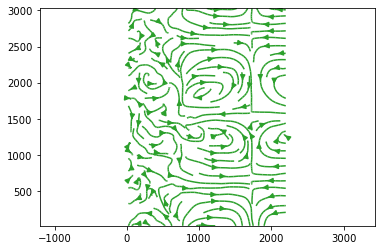

In [13]:
t = 180
print(vel.shape)
plt.streamplot(x[::4,::4], y[::4,::4], vel[t, ::4, ::4, 0], vel[t, ::4, ::4, 1], color="tab:green")

plt.axis("equal")

In [19]:
# define initial conditions

sk = 1
pad_width = 500

cut_dv = np.argmin(y[:,0] < pad_width)
cut_ap = np.argmin((x[0,:] - 1738) < 0)
extra_ap = (2, 2)

#initial = np.stack([x[cut_dv:-cut_dv, extra_ap[0]:cut_ap-extra_ap[1]][::sk, ::sk],
#                    y[cut_dv:-cut_dv, extra_ap[0]:cut_ap-extra_ap[1]][::sk, ::sk]], axis=-1)

skip = 2

initial = np.stack(np.meshgrid(np.arange(x[0, extra_ap[0]], x[0, cut_ap-extra_ap[1]], skip),
                               np.arange(y[cut_dv, 0], y[-cut_dv, 0], skip)), axis=-1)
initial_shape = initial.shape[:2]

initial = initial.reshape((np.prod(initial.shape[:2]),2))

In [20]:
print(initial_shape)

(1032, 832)


## Run intergration

In [21]:
phi = advect(vel_smoothed, x[0,:], y[:,0], np.arange(198-1), t_span=(30, 170),
             initial_conds=initial)

  0%|          | 0/858624 [00:00<?, ?it/s]

In [22]:
np.save("trajectories_very_fine.npy", phi)

(-74.05239100297098, 1896.7518080823643, 381.9392542638876, 2858.493466198799)

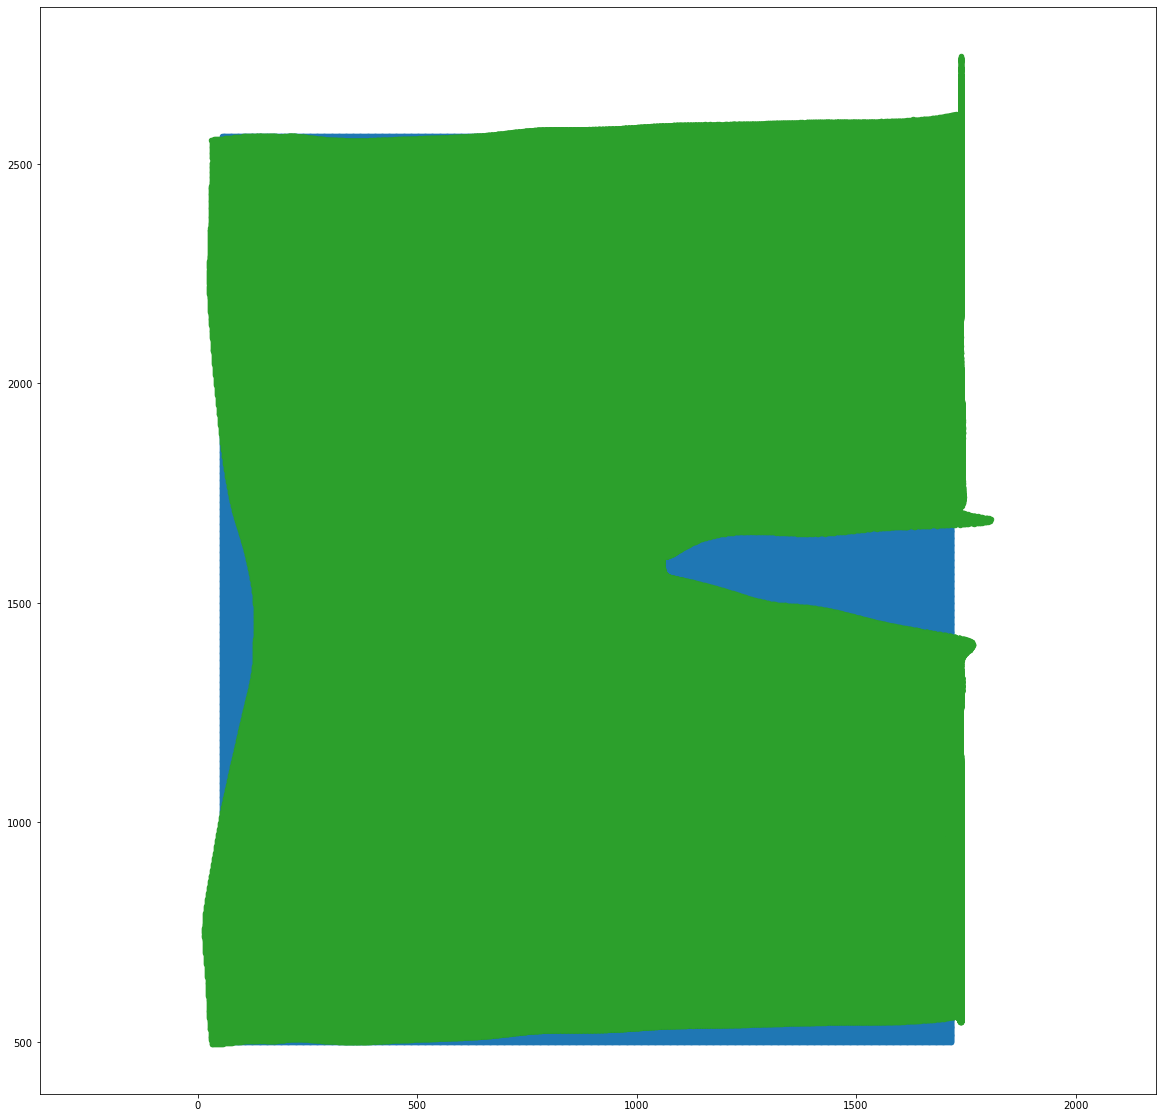

In [23]:
# plot trajectories

t  = 140

fig = plt.figure(figsize=(20,20))

plt.scatter(*phi[0].T, c="tab:blue", s=20)
plt.scatter(*phi[-1].T, c="tab:green", s=20)
    
plt.axis("equal")

## load trajectories

In [24]:
phi = np.load("trajectories_very_fine.npy")

## fix points for interpolation

In [25]:
X_interp, Y_interp = np.meshgrid(np.arange(0, 1730), np.arange(510, 2540))

## detect furrows if desired

In [26]:
t = 120

phi_reshaped = phi[t].reshape(initial_shape+(2,))

areas_lagrangian = -np.linalg.det(np.stack([np.gradient(phi_reshaped, axis=0),
                                            np.gradient(phi_reshaped, axis=1)], axis=-1))

# this needs to be interpolated back onto a grid
interpolator = LinearNDInterpolator(phi[t], areas_lagrangian.reshape(np.prod(areas_lagrangian.shape)))
areas_eulerian = interpolator(X_interp, Y_interp)
areas_eulerian = ndimage.gaussian_filter(areas_eulerian, sigma=1)

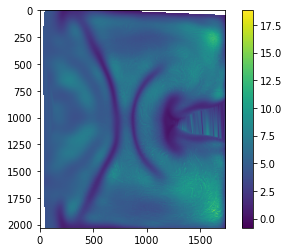

In [27]:
plt.imshow(areas_eulerian)
plt.colorbar()

In [28]:
areas_all = []

for final_position in tqdm(phi):
    reshaped = final_position.reshape(initial_shape+(2,))
    areas_lagrangian = -np.linalg.det(np.stack([np.gradient(reshaped, axis=0),
                                                np.gradient(reshaped, axis=1)], axis=-1))

    # this needs to be interpolated back onto a grid
    interpolator = LinearNDInterpolator(phi[t], areas_lagrangian.reshape(np.prod(areas_lagrangian.shape)))
    areas_eulerian = interpolator(X_interp, Y_interp)
    areas_eulerian = ndimage.gaussian_filter(areas_eulerian, sigma=1)
    areas_all.append(areas_eulerian)
    
areas_all = np.stack(areas_all)

  0%|          | 0/141 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.imshow(areas_all[100] > 64/2)


## mask of dorsal region

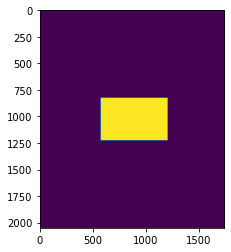

In [29]:
# create mask

initial = np.zeros((2050, 1738))

initial[825:1225, 570:1200] = 1

plt.imshow(initial)

In [30]:
# we need to pad the image periodically so we don't get interpolation errors

initial = pad_img(initial)

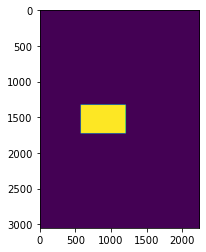

In [31]:
plt.imshow(initial)

In [33]:
## interpolate using trajectories

sigma = (1, 1) # (20, 10) (15, 7.5)

intial_vals = initial[phi[0,:,1].astype(int), phi[0,:,0].astype(int)]
initial_pos = phi[0]

interpolated = []
for final_pos in tqdm(phi[::2]):
    interpolator = LinearNDInterpolator(final_pos, intial_vals, fill_value=0)
    frame = interpolator(X_interp, Y_interp)

    frame = smooth_aniso(frame, sigma=sigma)
    frame = np.round(np.clip(frame, 0, 2) * 128).astype(np.uint8)

    interpolated.append(frame)

interpolated = np.stack(interpolated)

  0%|          | 0/71 [00:00<?, ?it/s]

In [40]:
print(interpolated.shape)

(71, 2030, 1730)


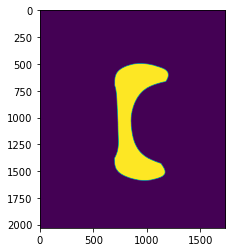

In [50]:
plt.imshow(interpolated[-1])

In [38]:
io.imsave("dorsal_mask_advected_dt2.tif", interpolated)

(35,)


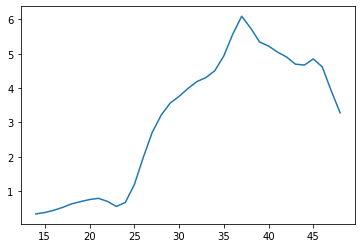

In [21]:
# timing

t = np.arange((170-30)/4)

t += 14
print(t.shape)


plt.plot(t, np.linalg.norm(vel_smoothed[30:170][::4], axis=-1).mean(axis=(1,2)))
# frame 8 I would say is VF initiation

In [23]:
np.save('data/dorsal_mask_time.npy', np.insert(t, 0, t[0]-1))